## Principal Components Analysis (PCA)

PCA is another term for SVD when it is used for dimension reduction, to which LSA is in part constructed from.
<br>
The PCA model in `sklearn` contains some tweaks to the **SVD** math that'll improve the accuracy of a NLP pipeline.
<br>
* operations - `sklearn.PCA` automatically ***centres*** the data by subtracting off the mean word frequencies. Additionally, a more subtle trick is that PCA uses a function known as `flip_sign` to compute the sign of the singular vectors
* optional - The `sklearn` implementation of PCA implements an optional 'whitening' step. This is also similar to the trick of ignoring the singular values when transforming word-document vectors into topic-document vectors. Also, instead of just setting all the singular values is $S$ to one, whitening divides the data by the variances similar to how `sklearn.StandardScalar` transform does. This helps spread out the data and make any optimisation algorithm less likely to get get confused parts of the data that can arise when features in our dataset are correlated with each other 

PCA is useful for a wide range of applications, which is helpful to know as it can perform data science techniques beyond NLP.
<br>
For most applied problems, we'll want to use the `sklearn.PCA` model for a LSA model.

As an initial example, We're going to begin with a set of real-world 3D vectors rather than +10k dimensional document-word vectors - given it's easier to visualise things in 3D than in 10000-D.

### PCA on 3D vectors 

SVD preserves the structure and information content of one's vectors by ***maximising*** the variance along the dimensions of our lower-dimensional 'shadow' of the high-dimensional space.
<br>
This is optimal for ML so that each low-dimensional vector captures the 'essence' of whatever it represents.
<br>
* heuristic - SVD ***maximises*** the variance along each axis (dimensions), to which variance turns out to be decent indicator of 'information' or the 'essence' one is searching for 

In [1]:
import pandas as pd 
import seaborn as sns 
pd.set_option('display.max_columns', 6)
from sklearn.decomposition import PCA # this is still technically SVD
from nlpia.data.loaders import get_data
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
df = get_data('pointcloud').sample(1000)
pca = PCA(n_components=2)

In [3]:
df2d = pd.DataFrame(pca.fit_transform(df), columns=list('xy'))
df2d.head()

,x,y
0,-0.010658,0.034572
1,0.049612,-0.018046
2,-0.012958,0.028803
3,0.061207,-0.034098
4,-0.004175,-0.003427


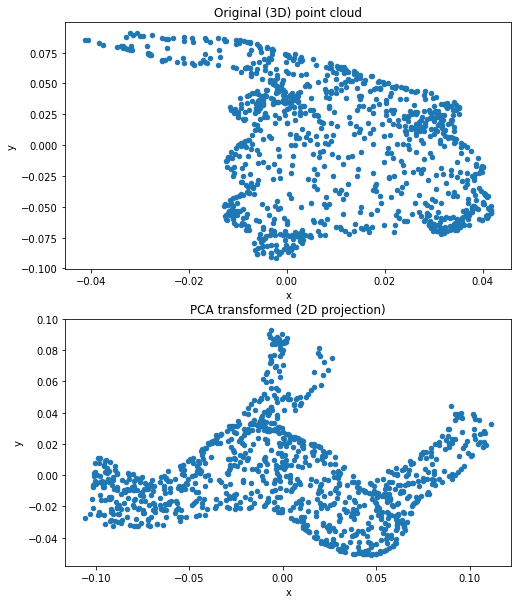

In [4]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=[8,10])
#plt.rcParams['figure.figsize'] = 8,12
df.plot(kind='scatter', x='x', y='y', ax=ax1, title='Original (3D) point cloud')
df2d.plot(kind='scatter', x='x', y='y', ax=ax2, title='PCA transformed (2D projection)')
plt.show();

The orientation of the 2D projection is computed so that the variance is always aligned with the x-axis (first axis).
<br>
The second largest variance is always aligned with the y-axis, the second dimension of our 'shadow'/'projection'.
<br>
Linear SVD and PCA do a good job of preserving the 'information' in the point cloud vector data 

### PCA (SVD) for NLP

Now, it's relevant to see how SVD will operate on natural language documents. 
This experiment will involve finding the principal components using SVD on the 5k SMS messages labelled as spam or not (ham).
<br>
Topic groupings should be small given a dataset with this sample size - limit to 16 topics.
<br> 
Within `sklearn`, there are two model methods to perform SVD on textual data, comparing the *differences*:
* `TruncatedSVD` - Created to work with ***sparse matrices***, where matrices have the same value (mostly zeros/NaNs) across many cells. This is almost always the case for BOW/TF-IDF word matrix transformations, given most documents don't contain many words of the words in our vocabulary. Hence, most of the word counts are zero
* `PCA` - Such model may provide a faster solution than the former (truncated SVD) by using dense matrices with all those zeros filled in. Although this comes at the cost of excessive RAM given it attempts to remember every single one of the zeros that are duplicated all over the place. Hence, when using `TfidfVectorizer`, it'll output sparse matrices, so we need to convert to dense matrices before we compare the results to PCA


In [5]:
import pandas as pd 
from nlpia.data.loaders import get_data
pd.options.display.width = 120 

In [7]:
sms = get_data('sms-spam')
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)]
sms.index = index 
sms.head(6)

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...
